# Identificación de modos ocultos en un sistema autoregresivo con switching

Este experimento simula un **sistema autoregresivo con parámetros que cambian de acuerdo a una cadena de Markov oculta** (Hidden Markov Model - HMM).

- **Simulación:**
  - Dos modos posibles (0 y 1), cada uno con sus propios parámetros `a` y `b`.
  - La salida `y[k]` depende del modo activo, de la entrada `u[k]` y de ruido gaussiano.
  - La evolución de los modos sigue la **matriz de transición `P`**.

- **Objetivo:**
  - Dado que los modos reales no son observables directamente, se aplica el **algoritmo de Viterbi** para estimar la secuencia de modos más probable.

- **Algoritmo de Viterbi (versión simplificada):**
  - Inicializa la verosimilitud para cada modo en `k=0`.
  - En cada paso:
    1. Calcula la probabilidad de transición desde modos anteriores.
    2. Evalúa la verosimilitud del error de predicción `y[k] - (a_j * y[k-1] + b_j * u[k-1])`.
    3. Propaga el mejor camino (dinámica de programación).
  - Al final, reconstruye la secuencia de modos mediante **backtracking**.

- **Resultados:**
  - Gráfico de la salida `y[k]`.
  - Secuencia real de modos vs. secuencia estimada por Viterbi.
  - Permite ver qué tan bien se recuperan los modos ocultos a partir de la salida ruidosa.

En síntesis: se trata de un ejemplo práctico de **detección de modos ocultos** en un sistema con parámetros variables, usando un HMM autoregresivo y el algoritmo de Viterbi para inferir la secuencia más probable de estados.


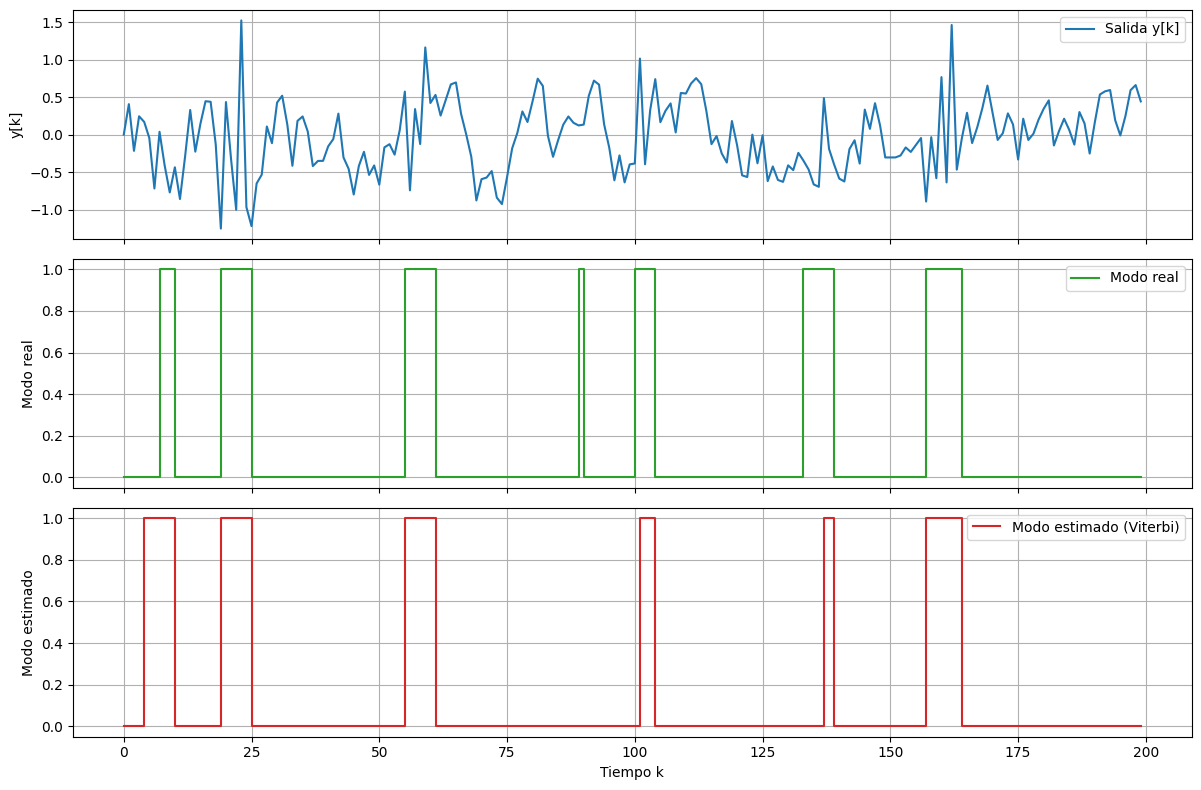

In [2]:
# Identificación de modo oculto en un sistema autoregresivo con switching

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Simulación del sistema
# -----------------------------
np.random.seed(42)

# Parámetros del sistema
a = [0.7, -0.3]
b = [0.5, 1.2]
sigma = 0.1

# Matriz de transición Markoviana
P = np.array([[0.95, 0.05],
              [0.1,  0.9]])

# Inicialización\N
N = 200
s_true = np.zeros(N, dtype=int)  # modos verdaderos
s_true[0] = np.random.choice([0, 1])
y = np.zeros(N)
u = np.random.uniform(-1, 1, N)
v = np.random.normal(0, sigma, N)

# Simular sistema con modos ocultos
for k in range(1, N):
    s_true[k] = np.random.choice([0, 1], p=P[s_true[k-1]])
    y[k] = a[s_true[k]] * y[k-1] + b[s_true[k]] * u[k-1] + v[k]

# -------------------------------------
# 2. Estimación de modos usando Viterbi
# -------------------------------------
def viterbi(y, u, a, b, sigma, P):
    N = len(y)
    M = len(a)  # cantidad de modos

    # Inicialización
    delta = np.zeros((N, M))  # log-probabilidad máxima
    psi = np.zeros((N, M), dtype=int)  # índices de retroceso

    # Paso inicial (asumimos y[0] = 0 conocido)
    for j in range(M):
        y_pred = a[j] * 0 + b[j] * u[0]
        error = y[0] - y_pred
        delta[0, j] = -0.5 * (error**2 / sigma**2)  # log-likelihood simplificado

    # Recursión
    for k in range(1, N):
        for j in range(M):
            probs = delta[k-1] + np.log(P[:, j])
            psi[k, j] = np.argmax(probs)

            y_pred = a[j] * y[k-1] + b[j] * u[k-1]
            error = y[k] - y_pred
            delta[k, j] = np.max(probs) - 0.5 * (error**2 / sigma**2)

    # Backtracking
    s_est = np.zeros(N, dtype=int)
    s_est[-1] = np.argmax(delta[-1])
    for k in reversed(range(1, N)):
        s_est[k-1] = psi[k, s_est[k]]

    return s_est

s_est = viterbi(y, u, a, b, sigma, P)

# -----------------------------
# 3. Gráficos de resultados
# -----------------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(y, label="Salida y[k]", color='tab:blue')
ax[0].set_ylabel("y[k]")
ax[0].legend()
ax[0].grid(True)

ax[1].step(range(N), s_true, where='post', label="Modo real", color='tab:green')
ax[1].set_ylabel("Modo real")
ax[1].legend()
ax[1].grid(True)

ax[2].step(range(N), s_est, where='post', label="Modo estimado (Viterbi)", color='tab:red')
ax[2].set_ylabel("Modo estimado")
ax[2].set_xlabel("Tiempo k")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()
